In [1]:
import numpy as np
import pandas as pd
prices_df = pd.read_csv('KO.csv', parse_dates=['Date'], index_col=['Date'])
prices_df[:3]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02,0.050381,0.051752,0.050381,0.050381,806400,0.0,0.0
1962-01-03,0.049632,0.049632,0.048510,0.049258,1574400,0.0,0.0
1962-01-04,0.049383,0.050006,0.049383,0.049632,844800,0.0,0.0


In [3]:
df = prices_df['Close']
df[:3]

Date
1962-01-02    0.050381
1962-01-03    0.049258
1962-01-04    0.049632
Name: Close, dtype: float64

In [9]:
split = int(0.8 * len(df))
train_set = df[:split]
validation_set = df[split:]
len(train_set), len(validation_set)

(12188, 3048)

In [6]:
train_set[:3]

Date
1962-01-02    0.050381
1962-01-03    0.049258
1962-01-04    0.049632
Name: Close, dtype: float64

In [8]:
validation_set[:3]

Date
2010-06-03    18.047714
2010-06-04    17.541357
2010-06-07    17.380547
Name: Close, dtype: float64

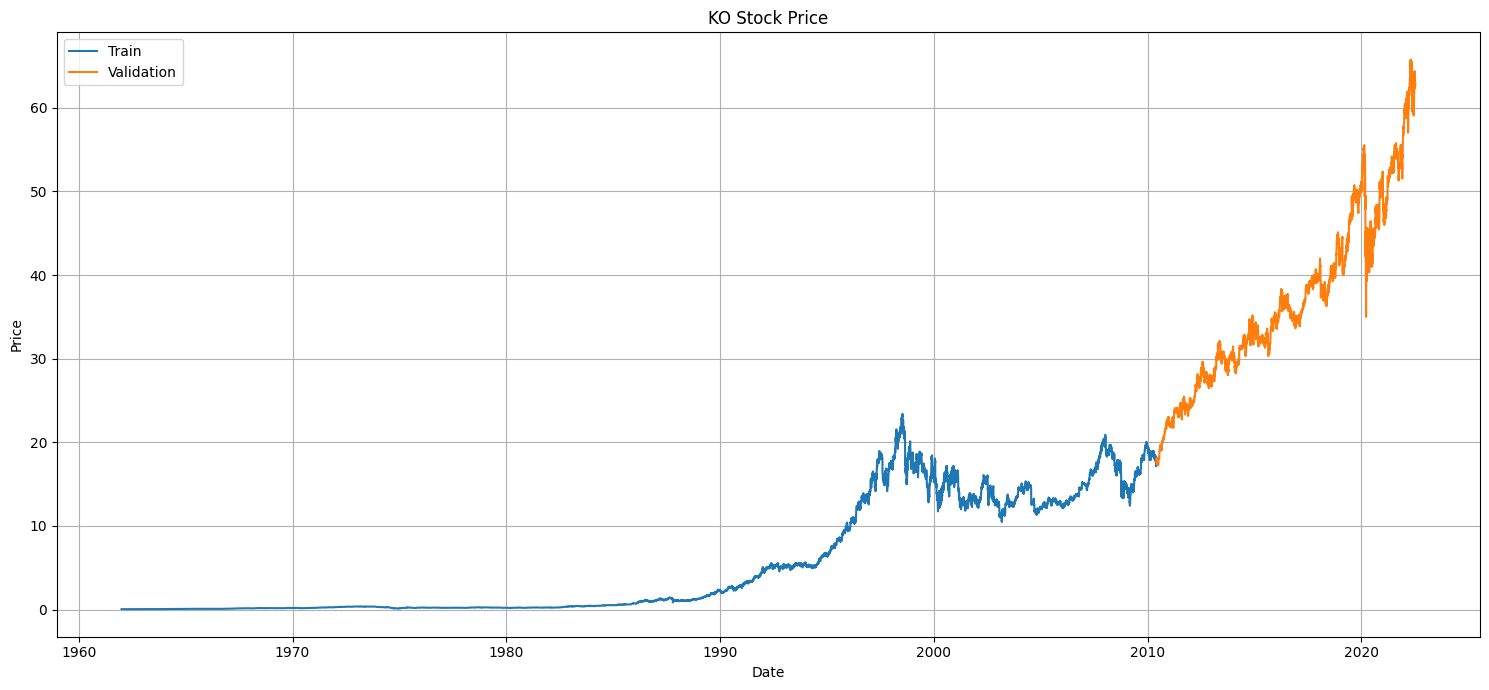

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(train_set.index, train_set, '-', label='Train')
plt.plot(validation_set.index, validation_set, '-', label='Validation')
plt.title('KO Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
import tensorflow as tf
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_set[:-30],
    targets=train_set[30:],
    shuffle=False,
    sequence_length=30,
    batch_size=len(train_set)
)
validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=validation_set[:-30],
    targets=validation_set[30:],
    shuffle=False,
    sequence_length=30,
    batch_size=len(validation_set)
)

In [13]:
import numpy as np
for train_batch in train_dataset:
    x_train, y_train = train_batch
    assert np.array_equal(x_train[0], train_set[:30])
    assert np.array_equal(y_train[0], train_set[30])
    break
for validation_batch in validation_dataset:
    x_test, y_test = validation_batch
    assert np.array_equal(x_test[0], validation_set[:30])
    assert np.array_equal(y_test[0], validation_set[30])
    break

len(x_train), len(y_train), len(x_test), len(y_test)

(12129, 12129, 2989, 2989)

In [14]:
train_index = train_set.index[30:len(y_train)+30]
validation_index = validation_set.index[30:len(y_test)+30]

len(train_index), len(validation_index)

(12129, 2989)

In [15]:
import os
def create_checkpoint_callback(model_name, filename='KO time series/'):
    path = os.path.join(filename, model_name)
    callback = tf.keras.callbacks.ModelCheckpoint(path, save_best_only=True)
    return [callback]

# Model 1: Dense model

In [ ]:
from keras import layers
inputs = layers.Input(shape=(30,), name='input_layer')
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_1 = tf.keras.models.Model(inputs, outputs, name='model_1_dense')

model_1.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae', 'accuracy']
)

history_model_1 = model_1.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_1.name)
)

In [18]:
model_1.evaluate(validation_dataset)

1/1 [==============================] - 1s 574ms/step - loss: 5.7102 - mae: 1.7644 - accuracy: 0.0000e+00


[5.710180759429932, 1.7644027471542358, 0.0]

In [19]:
model_1 = tf.keras.models.load_model('KO time series/model_1_dense')
model_1.evaluate(validation_dataset)

1/1 [==============================] - 1s 650ms/step - loss: 2.9267 - mae: 1.1224 - accuracy: 0.0000e+00


[2.926687479019165, 1.1223855018615723, 0.0]

In [20]:
mae_model_1 = model_1.evaluate(validation_dataset)[1]
mae_model_1

1/1 [==============================] - 1s 590ms/step - loss: 2.9267 - mae: 1.1224 - accuracy: 0.0000e+00


1.1223855018615723

# Model_2: conv1D model

In [ ]:
inputs = layers.Input(shape=(30,), name='input_layer')
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.Conv1D(filters=8, kernel_size=24, activation='relu', padding='causal', strides=1)(x)
x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = layers.Conv1D(filters=8, kernel_size=12, activation='relu', padding='causal')(x)
x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = layers.Conv1D(filters=8, kernel_size=6, activation='relu', padding='causal')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model_2 = tf.keras.models.Model(inputs, outputs, name='model_2_conv1d')

model_2.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_2 = model_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_2.name)
)

In [36]:
model_2.evaluate(validation_dataset)

1/1 [==============================] - 1s 546ms/step - loss: 328.0071 - mae: 17.4111


[328.00714111328125, 17.411123275756836]

In [37]:
model_2 = tf.keras.models.load_model('KO time series/model_2_conv1d')
mae_model_2 = model_2.evaluate(validation_dataset)[1]
mae_model_2

1/1 [==============================] - 1s 659ms/step - loss: 328.0071 - mae: 17.4111


17.411123275756836

# Model 3: LSTM Model

In [ ]:
inputs = layers.Input(shape=(30,))
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.25)(x)
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.25)(x)
x = layers.LSTM(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model_3 = tf.keras.models.Model(inputs, outputs, name='model_3_lstm')

model_3.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_3 = model_3.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_3.name)
)

In [39]:
model_3.evaluate(validation_dataset)

1/1 [==============================] - 1s 547ms/step - loss: 1256.3965 - mae: 33.9525


[1256.396484375, 33.9525260925293]

In [40]:
model_3 = tf.keras.models.load_model('KO time series/model_3_lstm')
mae_model_3 = model_3.evaluate(validation_dataset)[1]
mae_model_3

1/1 [==============================] - 1s 953ms/step - loss: 1256.3965 - mae: 33.9525


33.9525260925293

# Model 4: same as model 3 but with activation relu

In [ ]:
inputs = layers.Input(shape=(30,))
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.25, activation='relu')(x)
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.25, activation='relu')(x)
x = layers.LSTM(32, recurrent_dropout=0.25, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model_4 = tf.keras.models.Model(inputs, outputs, name='model_4_lstm_relu_activation')

model_4.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_4 = model_4.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_4.name)
)

In [42]:
model_4.evaluate(validation_dataset)

1/1 [==============================] - 0s 436ms/step - loss: 6.5808 - mae: 2.1800


[6.580819606781006, 2.180011749267578]

In [44]:
model_4 = tf.keras.models.load_model('KO time series/model_4_lstm_relu_activation')
mae_model_4 = model_4.evaluate(validation_dataset)[1]
mae_model_4

1/1 [==============================] - 1s 950ms/step - loss: 1.4248 - mae: 0.8469


0.8468835353851318

In [45]:
mae_model_1, mae_model_2, mae_model_3, mae_model_4

(1.1223855018615723, 17.411123275756836, 33.9525260925293, 0.8468835353851318)

# Model 5: model with activation relu

In [ ]:
inputs = layers.Input(shape=(30), dtype=tf.float32)
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.GRU(32, activation='relu', return_sequences=True, recurrent_dropout=0.25)(x)
x = layers.GRU(32, activation='relu', return_sequences=True, recurrent_dropout=0.25)(x)
x = layers.GRU(32, activation='relu', recurrent_dropout=0.25)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model_5 = tf.keras.models.Model(inputs, outputs, name='model_5_gru_activation_relu')

model_5.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_5 = model_5.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_name=model_5.name)
)

In [47]:
model_5.evaluate(validation_dataset)

1/1 [==============================] - 1s 519ms/step - loss: 11.9055 - mae: 2.9810


[11.90545654296875, 2.980990171432495]

In [48]:
model_5 = tf.keras.models.load_model('KO time series/model_5_gru_activation_relu')
mae_model_5 = model_5.evaluate(validation_dataset)[1]
mae_model_5

1/1 [==============================] - 1s 1s/step - loss: 2.0396 - mae: 0.9537


0.9536618590354919

# Model 6: Bidirectional model - LSTM

In [ ]:
inputs = layers.Input(shape=(30,), dtype=tf.float32, name='input_layer')
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=True, recurrent_dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=True, recurrent_dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', recurrent_dropout=0.25))(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model_6 = tf.keras.models.Model(inputs, outputs, name='model_6')

model_6.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_6 = model_6.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_6.name)
)

In [69]:
model_6.evaluate(validation_dataset)

1/1 [==============================] - 0s 476ms/step - loss: 1.9361 - mae: 0.9783


[1.9360603094100952, 0.9782935380935669]

In [70]:
model_6 = tf.keras.models.load_model('KO time series/model_6')
mae_model_6 = model_6.evaluate(validation_dataset)[1]
mae_model_6

1/1 [==============================] - 1s 1s/step - loss: 1.5836 - mae: 0.7611


0.7610902786254883

# Model 7 same as model 4 but 200 epoch

In [ ]:
inputs = layers.Input(shape=(30,))
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.25, activation='relu')(x)
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.25, activation='relu')(x)
x = layers.LSTM(32, recurrent_dropout=0.25, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model_7 = tf.keras.models.Model(inputs, outputs, name='model_7_lstm_relu_activation_200_epochs')

model_7.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_7 = model_7.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_7.name)
)

In [55]:
model_7.evaluate(validation_dataset)

1/1 [==============================] - 0s 461ms/step - loss: 16.1864 - mae: 3.2593


[16.186405181884766, 3.259343385696411]

In [64]:
model_7 = tf.keras.models.load_model('KO time series/model_7_lstm_relu_activation_200_epochs')
mae_model_7 = model_7.evaluate(validation_dataset)[1]
mae_model_7

1/1 [==============================] - 1s 961ms/step - loss: 1.2359 - mae: 0.7884


0.7883896231651306

# Model 8: same as model 6 but with 200 epochs

In [ ]:
inputs = layers.Input(shape=(30,), dtype=tf.float32, name='input_layer')
x = layers.Lambda(lambda x:tf.expand_dims(x, axis=1))(inputs)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=True, recurrent_dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=True, recurrent_dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', recurrent_dropout=0.25))(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model_8 = tf.keras.models.Model(inputs, outputs, name='model_8_bidirectional_200_epochs')

model_8.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

history_model_8 = model_8.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=create_checkpoint_callback(model_6.name)
)

In [75]:
model_8.evaluate(validation_dataset)

1/1 [==============================] - 0s 455ms/step - loss: 3.5064 - mae: 1.2799


[3.5063905715942383, 1.2799270153045654]

In [76]:
model_8 = tf.keras.models.load_model('KO time series/model_6')
mae_model_8 = model_8.evaluate(validation_dataset)[1]
mae_model_8

1/1 [==============================] - 1s 1s/step - loss: 1.5819 - mae: 0.8178


0.8177551031112671

In [77]:
import pandas as pd
models_results = pd.DataFrame({
    'Model 1':mae_model_1,
    'Model 2':mae_model_2,
    'Model 3':mae_model_3,
    'Model 4':mae_model_4,
    'Model 5':mae_model_5,
    'Model 6':mae_model_6,
    'Model 7':mae_model_7,
    'Model 8':mae_model_8,
}, index=['mean_abs_error'])
models_results.T

,mean_abs_error
Model 1,1.122386
Model 2,17.411123
Model 3,33.952526
Model 4,0.846884
Model 5,0.953662
Model 6,0.761090
Model 7,0.788390
Model 8,0.817755


# Making predictions into future for 250 days (using model 7)

In [79]:
future_days = 250
last_sample = df[-30:]
future_predictions = []
for day in range(future_days):
    next_pred = model_7.predict(tf.expand_dims(last_sample, axis=0))
    future_predictions.append(tf.squeeze(next_pred))
    last_sample = np.append(last_sample,next_pred)[1:]

1/1 [==============================] - 0s 14ms/step


In [81]:
start_data = df.index[-1] + np.timedelta64(1, 'D')
end_data = start_data + np.timedelta64(250, 'D')
start_data, end_data

(Timestamp('2022-07-13 00:00:00'), Timestamp('2023-03-20 00:00:00'))

In [83]:
future_index = np.arange(start_data, end_data, dtype='datetime64[D]')
len(future_index)

250

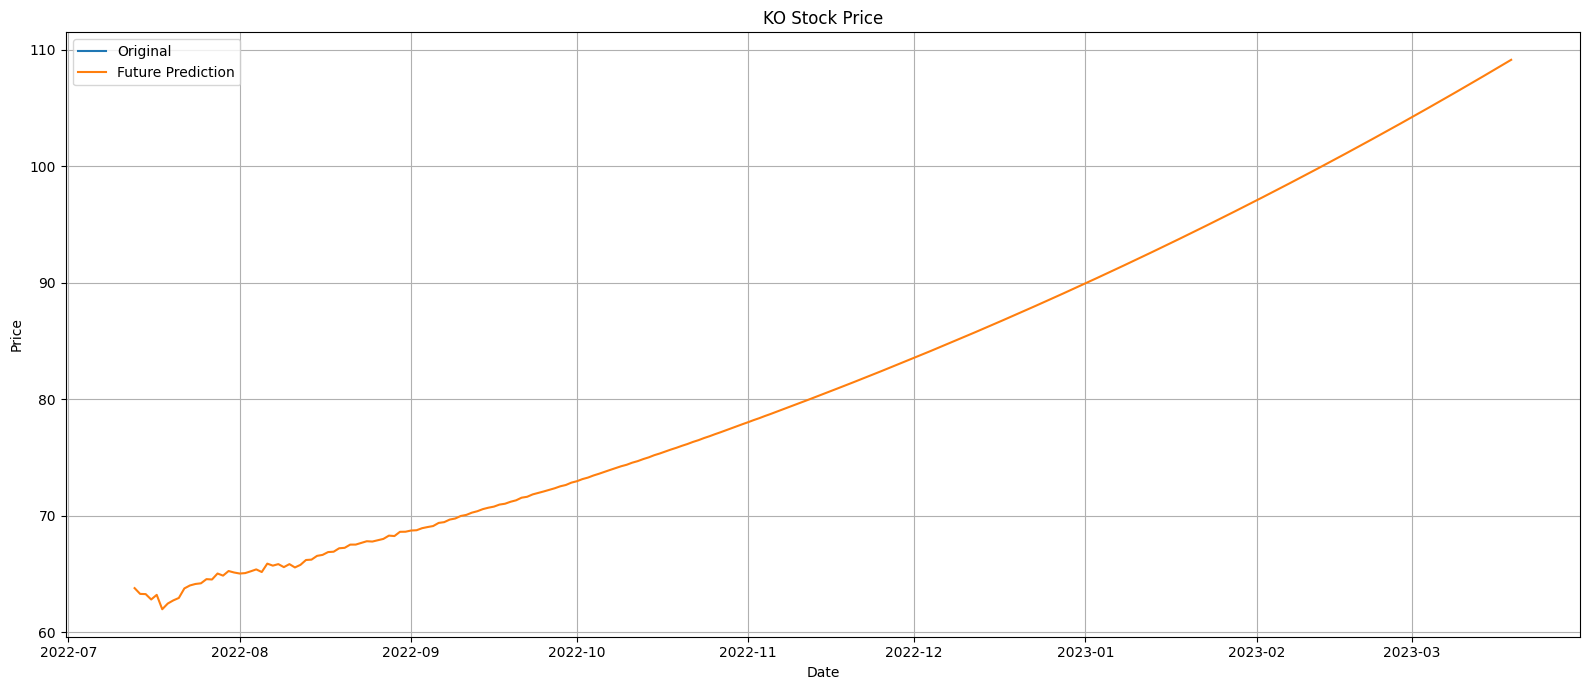

In [91]:
start=15150
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 7))
plt.grid()
plt.plot(df.index[start:], df[start:], '-', label='Original')
plt.plot(future_index, future_predictions, '-', label='Future Prediction')
plt.legend(loc='upper left')
plt.title('KO Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()